In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

2


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

## New topic: double gaussian psf...

1.0


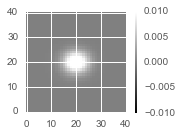

In [3]:
reload(dit)
psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.psf.doubleGaussian2d(x0, y0, 0, 0, a=0.9, sigma_x=3.0, sigma_y=3.5)
print psf.sum()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

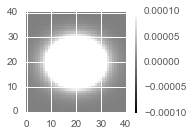

In [4]:
dit.plotImageGrid((psf,), clim=(-0.0001, 0.0001))

(ixx=12.9123732203, iyy=9.48680733984, ixy=0.0)
(ixx=12.2497431042, iyy=8.99978630007, ixy=-0.0)
(ixx=13.7640474984, iyy=10.1123404965, ixy=-0.0)


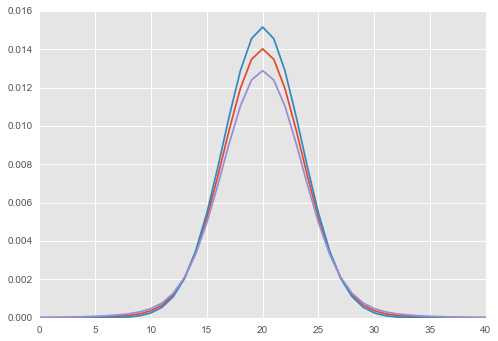

In [5]:
psf2 = dit.psf.singleGaussian2d(x0, y0, 0, 0, sigma_x=3.0, sigma_y=3.5, theta=0.)
psf3 = dit.psf.doubleGaussian2d(x0, y0, 0, 0, a=0.8, sigma_x=3.0, sigma_y=3.5)
print dit.afw.arrayToAfwPsf(psf).computeShape()
print dit.afw.arrayToAfwPsf(psf2).computeShape()
print dit.afw.arrayToAfwPsf(psf3).computeShape()
plt.plot(psf[20,:])
plt.plot(psf2[20,:])
plt.plot(psf3[20,:])

## Use `galsim` for Kolmogorov PSF...

9604
galsim.BoundsI(1,98,1,98) 98


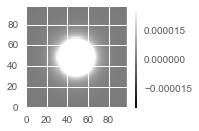

In [6]:
import galsim
#gsp = galsim.GSParams(folding_threshold=1.0/512., maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=3.5*0.2*2.355, flux=1) #, gsparams=gsp)
im = psf.drawImage(method='real_space', scale=0.2)
print im.image.array.size
bounds = im.getBounds()
print bounds, bounds.getXMax()
arr = im.image.array.reshape(bounds.getXMax(), bounds.getXMax())
dit.plotImageGrid((arr,))

1.6485
(ixx=13.9971286725, iyy=13.9971286725, ixy=0.27901747012)


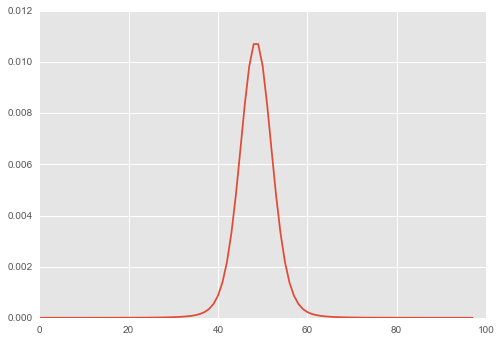

In [7]:
print psf.getFWHM()
print dit.afw.arrayToAfwPsf(arr).computeShape()
plt.plot(arr[bounds.getXMax()//2,:])

## Now a Moffat...

1.0
(ixx=14.1958993231, iyy=14.1958993231, ixy=0.0)


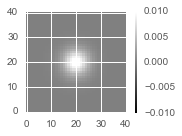

In [8]:
reload(dit)

psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.psf.moffat2d(x0, y0, 0, 0, 3.5*2.355)  # fwhm = 2.355 * sigma
print psf.sum()
print dit.afw.arrayToAfwPsf(psf).computeShape()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

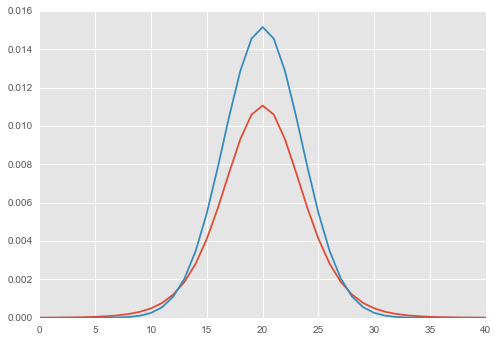

In [9]:
plt.plot(psf[20,:])
plt.plot(psf2[20,:])

## After adding these to `diffimTests.psf.makePsf` and `diffimTests.makeFakeImages`...

{'ZOGY': {'FP': 2, 'FN': 460, 'TP': 40}, 'ALstack': {'FP': 2, 'FN': 461, 'TP': 39}, 'SZOGY': {'FP': 3, 'FN': 461, 'TP': 39}, 'ALstack_decorr': {'FP': 2, 'FN': 461, 'TP': 39}}


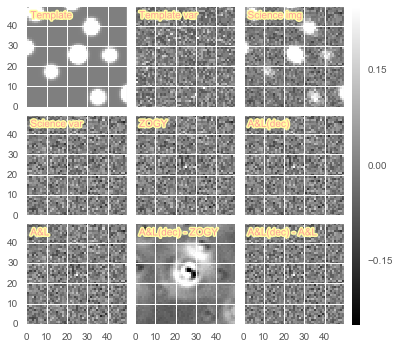

In [10]:
reload(dit)
testObj = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

res = testObj.runTest(returnSources=True)
src = res['sources']
del res['sources']
print res

tmp = dit.catalogToDF(testObj.getCentroidsCatalog(transientsOnly=False))
#dit.sizeme(tmp.tail())
testObj.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

{'ZOGY': {'FP': 3, 'FN': 466, 'TP': 34}, 'ALstack': {'FP': 2, 'FN': 466, 'TP': 34}, 'SZOGY': {'FP': 6, 'FN': 468, 'TP': 32}, 'ALstack_decorr': {'FP': 2, 'FN': 466, 'TP': 34}}


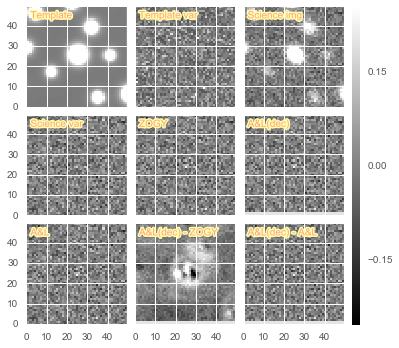

In [11]:
reload(dit)
testObj2 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='doubleGaussian')

res2 = testObj2.runTest(returnSources=True)
src2 = res2['sources']
del res2['sources']
print res2

testObj2.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

{'ZOGY': {'FP': 4, 'FN': 465, 'TP': 35}, 'ALstack': {'FP': 3, 'FN': 465, 'TP': 35}, 'SZOGY': {'FP': 4, 'FN': 465, 'TP': 35}, 'ALstack_decorr': {'FP': 3, 'FN': 465, 'TP': 35}}


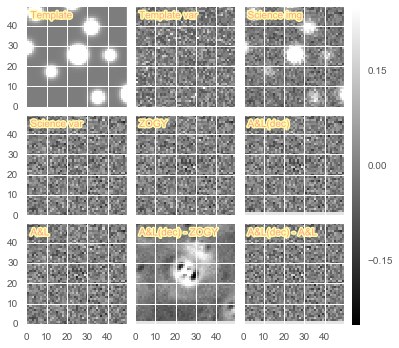

In [12]:
reload(dit)
testObj3 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='moffat')

res3 = testObj3.runTest(returnSources=True)
src3 = res3['sources']
del res3['sources']
print res3

testObj3.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

Kolmogorov works now, but is slow and there's still an issue with the A&L(dec) - ZOGY image.
Seems to be because of a 0.5-pixel offset in the psf.

In [13]:
reload(dit)
testObj4 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='kolmogorov')

res4 = testObj4.runTest(returnSources=True)
src4 = res4['sources']
del res4['sources']
print res4

{'ZOGY': {'FP': 10, 'FN': 472, 'TP': 28}, 'ALstack': {'FP': 7, 'FN': 469, 'TP': 31}, 'SZOGY': {'FP': 13, 'FN': 474, 'TP': 26}, 'ALstack_decorr': {'FP': 7, 'FN': 469, 'TP': 31}}


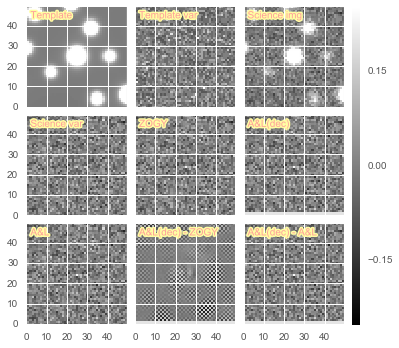

In [24]:
tmp = dit.catalogToDF(testObj.getCentroidsCatalog(transientsOnly=False))
testObj4.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);
#testObj4.doPlot();

In [15]:
print np.unravel_index(np.argmax(testObj.im2.psf), testObj.im2.psf.shape)
print np.unravel_index(np.argmax(testObj2.im2.psf), testObj2.im2.psf.shape)
print np.unravel_index(np.argmax(testObj3.im2.psf), testObj3.im2.psf.shape)
print np.unravel_index(np.argmax(testObj4.im2.psf), testObj4.im2.psf.shape)

print dit.afw.arrayToAfwPsf(testObj.im2.psf).computeShape()
print dit.afw.arrayToAfwPsf(testObj2.im2.psf).computeShape()
print dit.afw.arrayToAfwPsf(testObj3.im2.psf).computeShape()
print dit.afw.arrayToAfwPsf(testObj4.im2.psf).computeShape()

#dit.plotImageGrid((testObj.im2.psf, testObj2.im2.psf, testObj3.im2.psf, testObj4.im2.psf,))

(20, 20)
(20, 20)
(20, 20)
(20, 20)
(ixx=4.03994623804, iyy=4.03994623804, ixy=-0.799989278877)
(ixx=4.90711259462, iyy=4.90711259462, ixy=-0.971716519198)
(ixx=4.63417624379, iyy=4.63417624379, ixy=-0.0)
(ixx=4.54343857395, iyy=4.54343857395, ixy=-0.0)


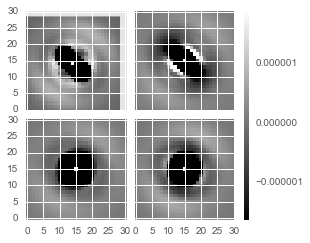

In [20]:
dit.plotImageGrid((testObj.ALres.decorrelationKernel, testObj2.ALres.decorrelationKernel,
                  testObj3.ALres.decorrelationKernel, testObj4.ALres.decorrelationKernel,))

{'ZOGY': {'FP': 2, 'FN': 460, 'TP': 40}, 'ALstack': {'FP': 2, 'FN': 461, 'TP': 39}, 'SZOGY': {'FP': 3, 'FN': 461, 'TP': 39}, 'ALstack_decorr': {'FP': 2, 'FN': 461, 'TP': 39}}


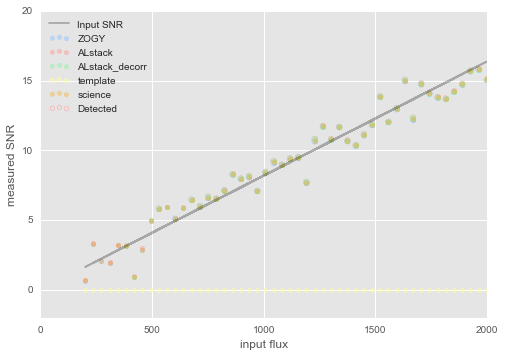

In [17]:
testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, divideByInput=False, addPresub=True)
plt.xlim(0, 2000)
plt.ylim(-2, 20);

This difference (below) is due to an issue probably with an offset in the PSFs.

{'ZOGY': {'FP': 10, 'FN': 472, 'TP': 28}, 'ALstack': {'FP': 7, 'FN': 469, 'TP': 31}, 'SZOGY': {'FP': 13, 'FN': 474, 'TP': 26}, 'ALstack_decorr': {'FP': 7, 'FN': 469, 'TP': 31}}


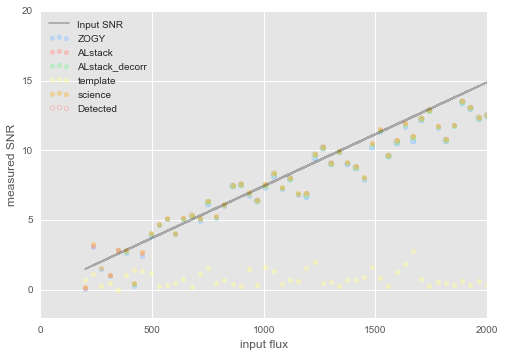

In [25]:
testObj4.doPlotWithDetectionsHighlighted(transientsOnly=True, divideByInput=False, addPresub=True)
plt.xlim(0, 2000)
plt.ylim(-2, 20);

In [26]:
print dit.psf.computeMoments(testObj.im2.psf)
print dit.psf.computeMoments(testObj2.im2.psf)
print dit.psf.computeMoments(testObj3.im2.psf)
print dit.psf.computeMoments(testObj4.im2.psf)

(20.0, 20.000000000000004)
(20.0, 20.0)
(20.0, 20.0)
(20.0, 20.0)


# Now for "real" psfs from real images. Try this:

Box2I((0, 0), (511, 511))
(ixx=4.2937886539, iyy=4.68256779165, ixy=-1.00958235705)


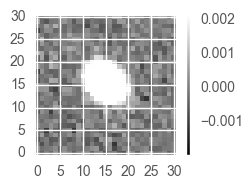

In [2]:
import lsst.afw.image as afwImage
# This image was a simulated image written out previously...
im = afwImage.ExposureF('test_imageDifference/test_dr1/deepDiff/im2/diffexp.fits')
print im.getBBox()
psf = im.getPsf()
print dit.afw.afwPsfToShape(psf, im)
dit.plotImageGrid((dit.afw.afwPsfToArray(psf, im),))

Box2I((0, 0), (2111, 4643))


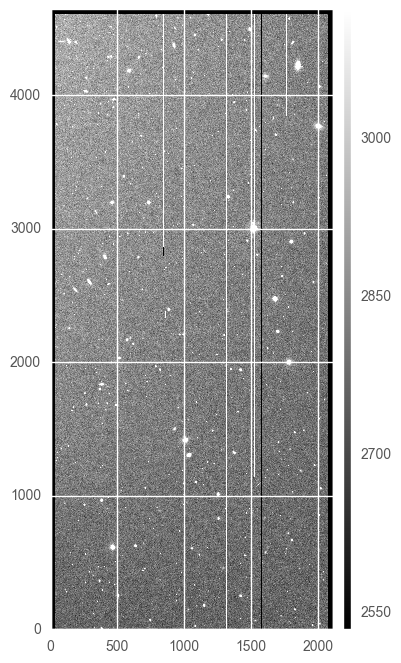

In [3]:
import os
import lsst.afw.image as afwImage
import diffimTests as dit

afwData = os.getenv('AFWDATA_DIR')
im = afwImage.ExposureF(afwData + '/CFHT/D4/cal-53535-i-797722_1.fits')
print im.getBBox()
dit.plotImageGrid((im.getMaskedImage().getImage(),), imScale=8.)

(ixx=2.98711664574, iyy=4.45245174118, ixy=-0.900905346003)


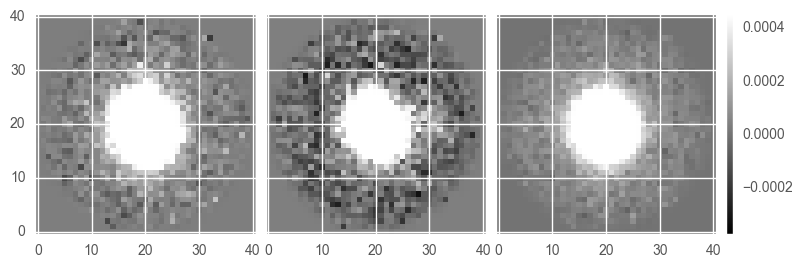

In [11]:
res = dit.tasks.doMeasurePsf(im, detectThresh=10.0, startSize=6.0, spatialOrder=2)
psf = res.psf #im.getPsf()
print dit.afw.afwPsfToShape(psf)
dit.plotImageGrid((dit.afw.afwPsfToArray(psf, im),
                   dit.afw.afwPsfToArray(psf, coord=[100,100]),
                  dit.afw.afwPsfToArray(psf, coord=[1500,4000])), imScale=3.)

<class 'lsst.meas.extensions.psfex.psfexLib.PsfexPsf'>


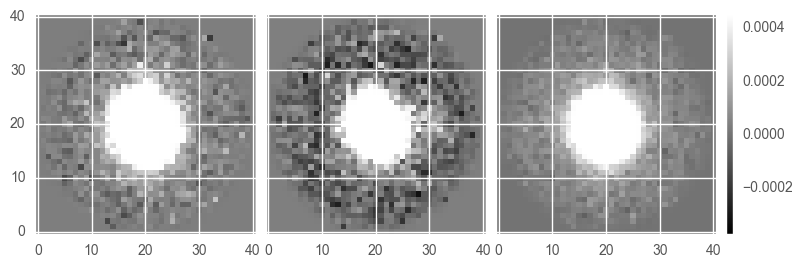

In [12]:
print type(psf)
psf.writeFits('cal-53535-i-797722_1_psf.fits')

import lsst.afw.detection as afwDet
psf2 = afwDet.Psf.readFits('cal-53535-i-797722_1_psf.fits')
dit.plotImageGrid((dit.afw.afwPsfToArray(psf2, im),
                   dit.afw.afwPsfToArray(psf2, coord=[100,100]),
                  dit.afw.afwPsfToArray(psf2, coord=[1500,4000])), imScale=3.)